In [37]:
import sys 
sys.path.append('../')
import_path = '../export/'

In [38]:
import pandas as pd
import seaborn as sns

def load_dataset(datasetname):
    df = pd.read_csv(datasetname)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df
def load_plain_and_perturbed_dataset(epsilon):
    dataset_name1 = import_path + 'plain.csv'
    dataset_name2 = import_path + 'perturbed_' + str(epsilon) + '.csv'
    dataset1 = load_dataset(dataset_name1)
    dataset2 = load_dataset(dataset_name2)
    return dataset1, dataset2

def compare_datasets(dataset1, dataset2, epsilon):
    sns.scatterplot(data=dataset1, x='X', y='Y', label='baseline')
    sns.scatterplot(data=dataset2, x='X', y='Y', label='epsilon: {eps}'.format(eps=epsilon))

def load_and_compare(epsilon):
    dataset1, dataset2 = load_plain_and_perturbed_dataset(epsilon)
    compare_datasets(dataset1, dataset2, epsilon)

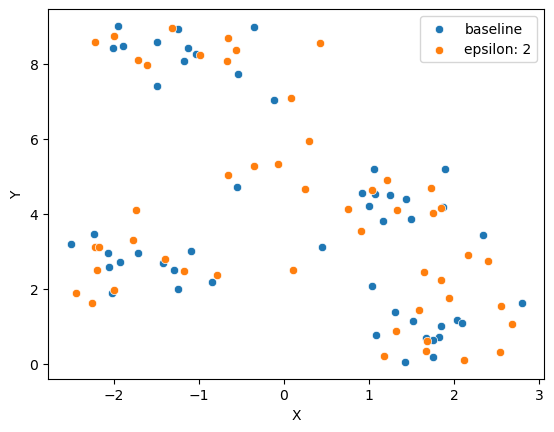

In [39]:
load_and_compare(2)

## Euclidean distance

In [40]:
epsilons = [0.05, 0.5, 1, 2, 3, 6]
export_path = import_path + 'privacy_scores'

In [41]:
import numpy as np


def Euclidean_Dist(df1, df2, cols=['X','Y']):
    return np.average(np.linalg.norm(df1[cols] - df2[cols],
                   axis=1))
def calculate_avg_distance_between_datasets(epsilon):
    plain_df, perturbed_df = load_plain_and_perturbed_dataset(epsilon)
    return Euclidean_Dist(plain_df, perturbed_df)

def calculate_avg_distance_for_epsilons(epsilons):
    dict = {'epsilon': [], 'distance': []}
    for epsilon in epsilons:
        distance = calculate_avg_distance_between_datasets(epsilon)
        dict['epsilon'].append(epsilon)
        dict['distance'].append(distance)
    pd.DataFrame(dict).to_csv(export_path + '/report.csv')


In [42]:
calculate_avg_distance_for_epsilons(epsilons)

### Plot

In [43]:
distances_per_epsilon = load_dataset(export_path + '/report.csv')
distances_per_epsilon.head()

,epsilon,distance
0,0.05,3.533754
1,0.50,2.306064
2,1.00,1.537704
3,2.00,0.864090
4,3.00,0.623855


<AxesSubplot:title={'center':'Average euclidean distance (privacy) of the perturbed dataset in comparison to plain dataset'}, xlabel='Privacy budget ($\\epsilon$)', ylabel='Average euclidean distance'>

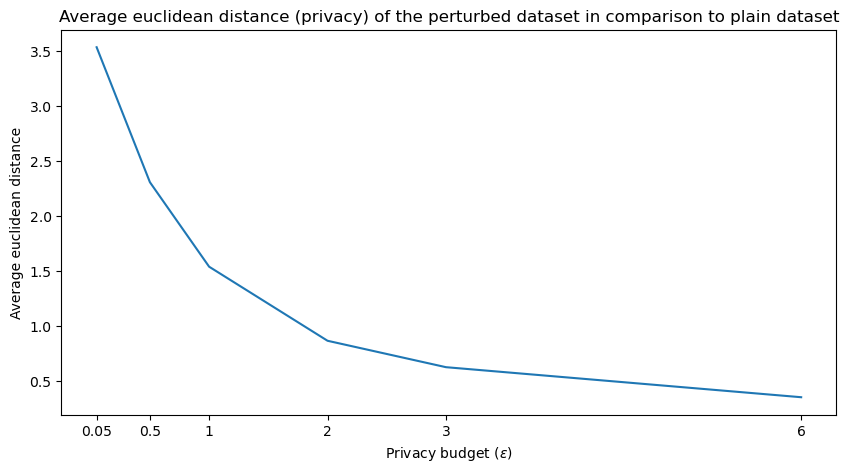

In [49]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Average euclidean distance (privacy) of the perturbed dataset in comparison to plain dataset')
ax.set_ylabel('Average euclidean distance')
ax.set_xlabel('Privacy budget ($\epsilon$)')
ax.set_xticks(epsilons, labels=epsilons)
sns.lineplot(data=distances_per_epsilon, x='epsilon', y='distance', ax=ax, markers='True')